# Exploratory Data Analysis

In [1]:
# Import libraries
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn import neighbors
from matplotlib.colors import ListedColormap

## Description of the Data

### Data Cleaning Process

### Data Structure

In [2]:
# Import the dataframe
playlist_df = pd.read_csv("data/playlists.csv", index_col = 0)
songs_df = pd.read_csv("data/songs_100000_feat_cleaned.csv", index_col = 0)
combined_df = pd.read_csv("data/subset100playlists.csv", index_col = 0)

/home/kaivalya/.anaconda3/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [3]:
combined_df.dtypes

index                 int64
pid                   int64
pos                   int64
track_uri            object
artist_uri_x         object
track_name           object
artist_name          object
artist_uri_y         object
album_name           object
album_uri            object
count                 int64
acousticness        float64
analysis_url         object
danceability        float64
duration_ms           int64
energy              float64
id                   object
instrumentalness    float64
key                   int64
liveness            float64
loudness            float64
mode                  int64
speechiness         float64
tempo               float64
time_signature        int64
track_href           object
type                 object
valence             float64
dtype: object

## Exploratory Data Analysis

### What is the composition of playlists in the cleaned dataset?

First, we investigate the high level composition of the playlists in our cleaned dataset. How many playlists and songs do we have? What is the distribution of the number of songs per playlist? Are certain songs used significantly more than others?

In [4]:
n_tracks = playlist_df.track_uri.nunique()
n_playlists = playlist_df.pid.nunique()

summary_stats = pd.DataFrame([{'Statistic': 'Unique Tracks', 'Value': n_tracks},
                              {'Statistic': 'Unique Playlists', 'Value': n_playlists}])

In [5]:
track_uri_stats = playlist_df.groupby('track_uri')['pid'].count().sort_values(ascending = False).cumsum()
weights = 1/track_uri_stats.max()
weighted_track_uri_stats = track_uri_stats * weights
cum_px = weighted_track_uri_stats[weighted_track_uri_stats.gt(0.9)].index[0]
cum_px = round(weighted_track_uri_stats.index.get_loc(cum_px)/n_tracks, 2)*100

In [6]:
pid_stats = playlist_df.groupby('pid')['track_uri'].count()

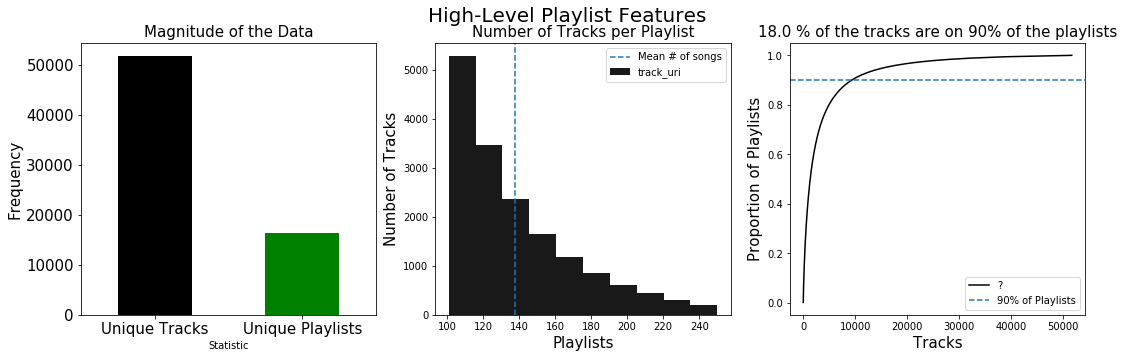

In [15]:
fig, ax = plt.subplots(1,3, figsize = (18,5))

ax[0].set_title('Magnitude of the Data', fontsize=15)
ax[0].set_ylabel('Frequency', fontsize=15)
summary_stats.plot.bar(x = 'Statistic', y='Value', color=['k','g'], rot=0, legend = False, ax = ax[0], fontsize=15)

ax[1].set_title('Number of Tracks per Playlist', fontsize=15)
ax[1].hist(pid_stats, color = 'k', alpha = 0.9)
ax[1].axvline(pid_stats.mean(), ls = '--', label = 'Mean # of songs')
ax[1].set_ylabel('Number of Tracks', fontsize=15)
ax[1].set_xlabel('Playlists', fontsize=15)
ax[1].legend()

ax[2].set_title(f'{cum_px} % of the tracks are on 90% of the playlists', fontsize=15)
ax[2].plot(np.arange(n_tracks), weighted_track_uri_stats, c = 'k', label='?')
ax[2].set_ylabel('Proportion of Playlists', fontsize=15)
ax[2].set_xlabel('Tracks', fontsize=15)
ax[2].axhline(0.9, ls = '--',  label = '90% of Playlists')
ax[2].legend()
plt.suptitle('High-Level Playlist Features\n\n', fontsize=20)
plt.show()

The plots above show immediately the impact of our playlist selection criteria on the dataset that will be used for training, testing, and validating our models.
* The number of songs per playlist is not normally distributed, and we only have playlists that include more than 100 songs.
* 18% of songs are on 90% of playlists. So we can expect overlap of songs between playlists.

### What do songs sound like?

In [8]:
song_feature_cols = ['acousticness', 'danceability', 'duration_ms',
               'energy', 'instrumentalness', 'key', 'liveness', 'loudness', 'speechiness',
               'tempo', 'time_signature', 'valence']

song_subset_df = songs_df[song_feature_cols]

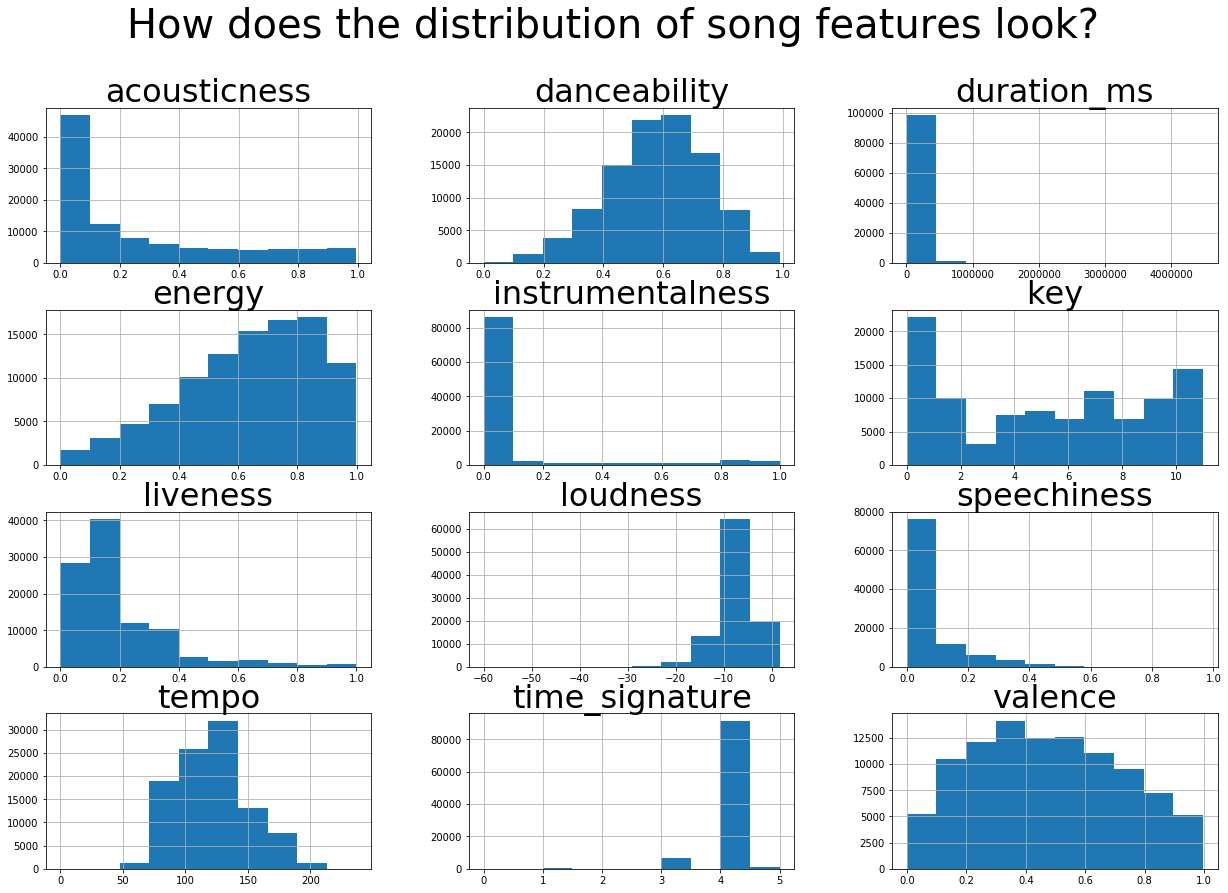

In [9]:
columns = song_subset_df.columns
fig = song_subset_df.hist(figsize=(21,14), column = columns)
plt.suptitle('How does the distribution of song features look?', fontsize=40)
[x.title.set_size(32) for x in fig.ravel()]
plt.show()

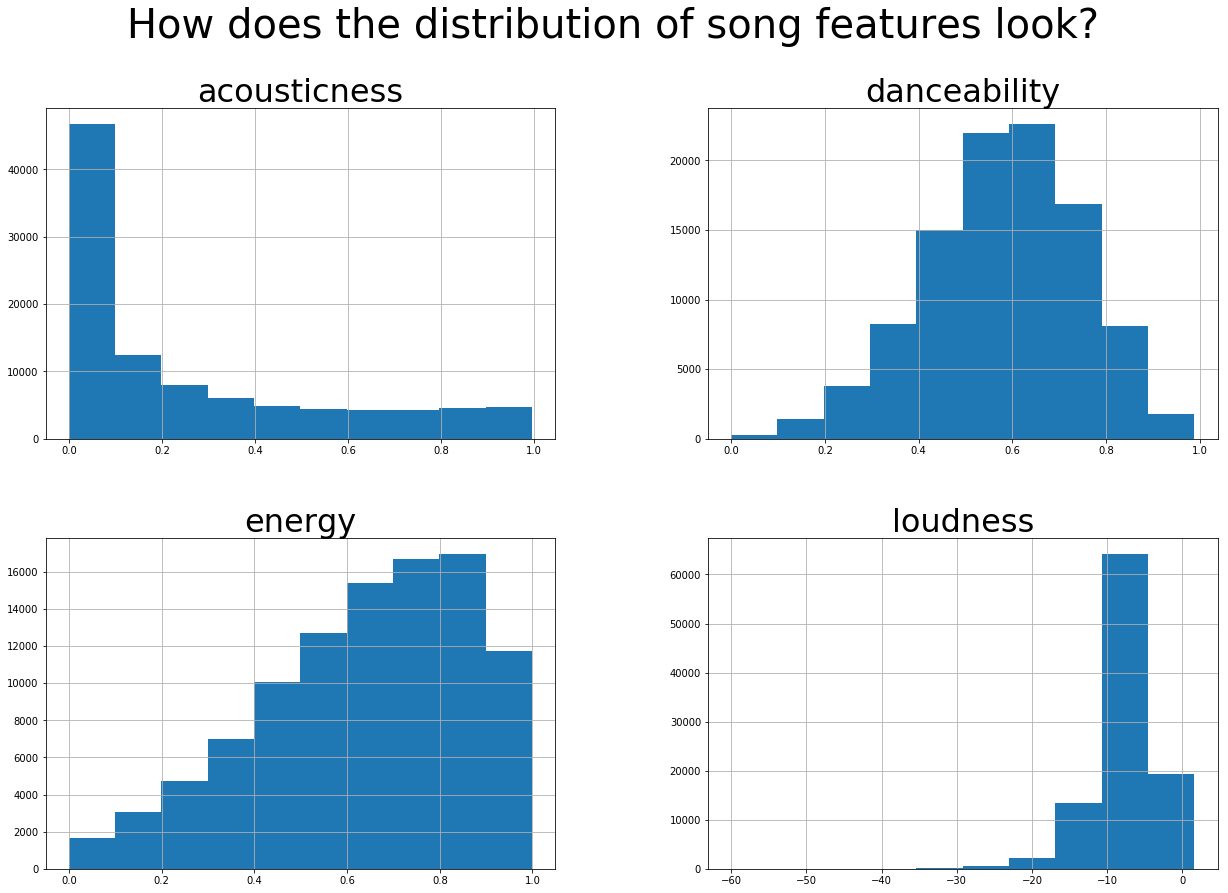

In [10]:
fig = song_subset_df.hist(figsize=(21,14), column=['acousticness','loudness','danceability','energy'])
plt.suptitle('How does the distribution of song features look?', fontsize=40)
[x.title.set_size(32) for x in fig.ravel()]
plt.show()

/home/kaivalya/.anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:334: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


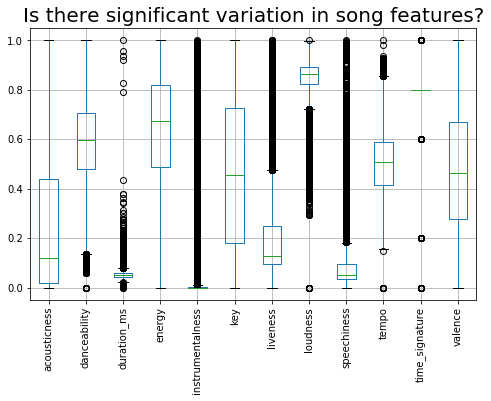

In [11]:
scaler = MinMaxScaler().fit(song_subset_df)
scaled_songs_df = pd.DataFrame(scaler.transform(song_subset_df), columns = columns)
plt.figure(figsize=(8,5))
scaled_songs_df.boxplot(figsize=(21,7))
plt.xticks(rotation=90)
plt.title('Is there significant variation in song features?', fontsize=20)
plt.show()

(array([ 0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5, 10.5,
        11.5]), <a list of 12 Text yticklabel objects>)

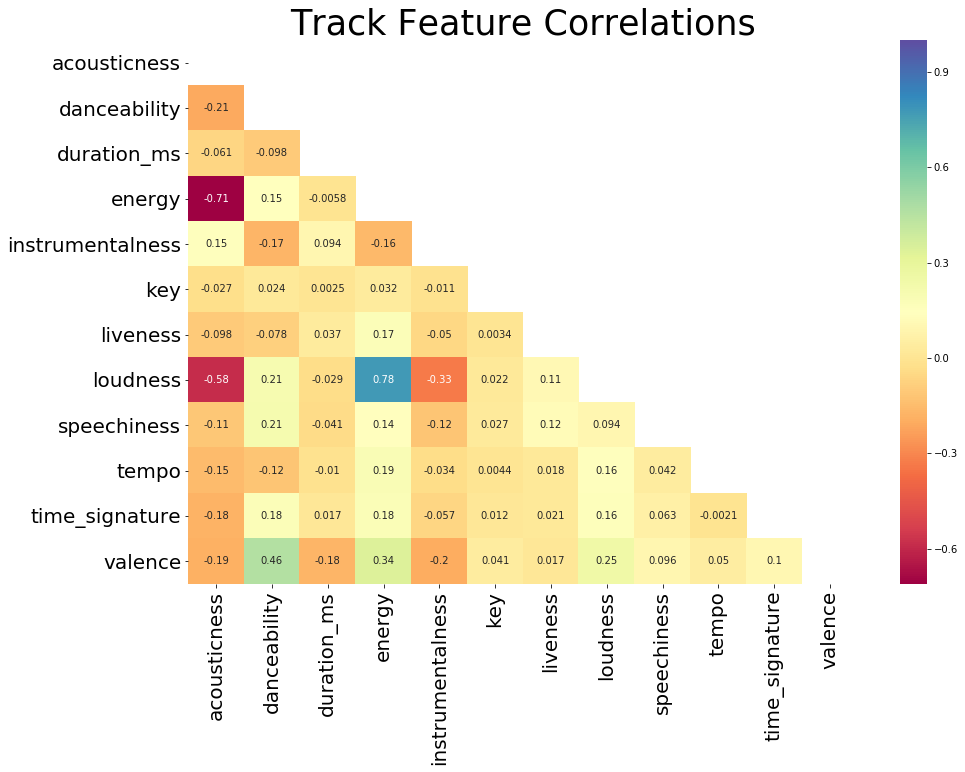

In [12]:
corr_mat = song_subset_df.corr()
mask = np.zeros_like(corr_mat)
mask[np.triu_indices_from(mask)] = True
        
plt.figure(figsize=(15,10))
plt.title('Track Feature Correlations', fontsize=35)
sns.heatmap(corr_mat, cmap='Spectral', annot=True, mask=mask)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)



### Do playlists tend to have very similar songs, or very different songs?

We wanted to know whether playlists in our training set tend to be built from songs that are similar to each other or songs that are different from each other. If the same songs appear in many playlists, we could perhaps identify these and recommend them. Alternatively, if playlists tend to be composed of songs that all have similar features, we could use information about the distribution of feature scores in a stub playlist to recommend additional songs for the playlist.

In [13]:
len(np.unique(playlist_df.pid))

16356

Text(0.5, 1.0, 'Number of Playlists that Tracks Appear In')

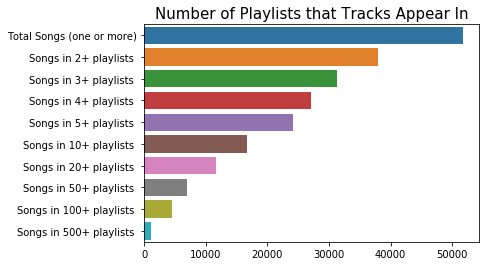

In [14]:
playlists_per_track = playlist_df.groupby('track_uri').count()
playlists_per_track = playlists_per_track.sort_values('pid', ascending=False)
l = [1,2,3,4,5,10,20,50,100,500]
ll = []
for i in l:
    ll.append(len(playlists_per_track[playlists_per_track['pid'] >= i]))
for i in range(1, len(l)):
    l[i] = 'Songs in ' + str(l[i]) + '+ playlists '
l[0] = 'Total Songs (one or more)'
barp = sns.barplot(ll,l, orient='h')
plt.title('Number of Playlists that Tracks Appear In', fontsize=15)


In [15]:
subset_cols = ['pid', 'acousticness', 'danceability', 'duration_ms', 'count',
               'energy', 'instrumentalness', 'key', 'liveness', 'loudness', 'speechiness',
               'tempo', 'time_signature', 'valence']

subset_df = combined_df[subset_cols]

In [16]:
def process_playlists(df, fun, along):
    index = df.eval(along).unique()
    columns = df.columns[df.columns != along]
    n_rows = len(index)
    n_columns = len(columns)
    
    # Construct output df
    output = pd.DataFrame(np.zeros((n_rows, n_columns)), index = index, columns = columns)

    # Loop through playslists and apply function
    for playlist in index:
        subset = df.loc[df['pid'] == playlist, columns]
        output.loc[playlist,:] = fun(subset)
    return output

In [17]:
def gini(x):
    # Mean absolute difference
    mad = x.mad()
    mean = x.mean()
    
    # Relative mean absolute difference
    rmad = abs(mad/mean)
    
    # Gini coefficient
    g = 0.5 * rmad
    return g

In [18]:
playlist_ginis = process_playlists(subset_df, gini, 'pid')

In [19]:
systemwide_playlist_ginis = gini(subset_df.groupby(['pid']).mean())
systemwide_playlist_ginis

acousticness        0.141604
danceability        0.040692
duration_ms         0.023532
count               0.138189
energy              0.036393
instrumentalness    0.461486
key                 0.023114
liveness            0.044011
loudness            0.070882
speechiness         0.200444
tempo               0.013098
time_signature      0.002967
valence             0.063992
dtype: float64

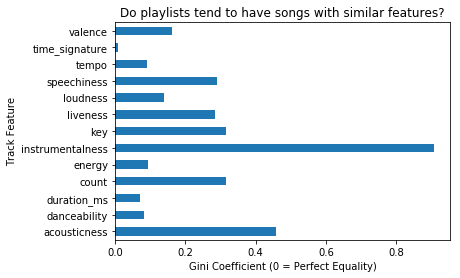

In [20]:
ax = playlist_ginis.mean().plot.barh()
ax.set_ylabel('Track Feature')
ax.set_xlabel('Gini Coefficient (0 = Perfect Equality)')
plt.title('Do playlists tend to have songs with similar features?')
plt.show()

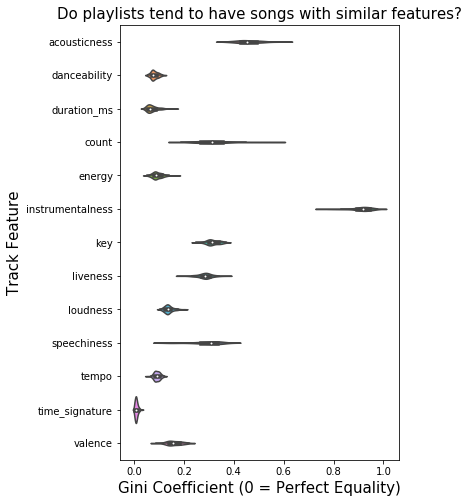

In [21]:
fig, ax = plt.subplots(figsize =(5, 8)) 
sns.violinplot(ax = ax, data = playlist_ginis, orient = 'h' )
ax.set_ylabel('Track Feature', fontsize=15)
ax.set_xlabel('Gini Coefficient (0 = Perfect Equality)', fontsize=15)
plt.title('Do playlists tend to have songs with similar features?', fontsize=15)
plt.show()

In [22]:

song_feature_cols = ['acousticness', 'danceability', 'duration_ms', 'count',
               'energy', 'instrumentalness', 'key', 'liveness', 'loudness', 'speechiness',
               'tempo', 'time_signature', 'valence']

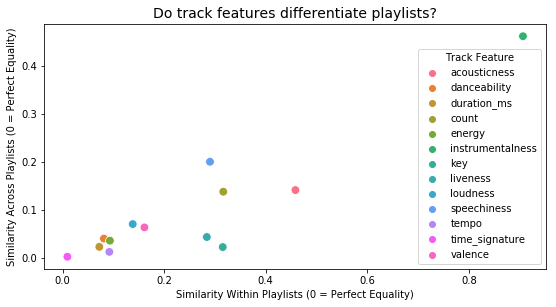

In [23]:
fig, ax = plt.subplots(figsize = (9,4.5))
ax = sns.scatterplot(playlist_ginis.mean(), systemwide_playlist_ginis, s = 75, hue = song_feature_cols)
ax.set_ylabel('Similarity Across Playlists (0 = Perfect Equality)')
ax.set_xlabel('Similarity Within Playlists (0 = Perfect Equality)')
ax.legend(title = 'Track Feature')
plt.title('Do track features differentiate playlists?', fontsize=14)
plt.show()

### Do natural clusters of songs emerge as playlists?

It seems from our exploratory analysis so far, that using song feature based methods to recommend songs that are "similar" to those already in a playlist is exceedingly difficult. To motivate this visually, we show a scatterplot of two arbitrary feature values, for songs in a few playlists.

Text(0.5, 1.0, 'Playlists do not Separate in Song feature-space')

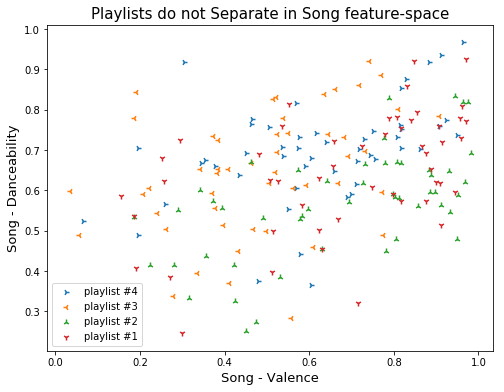

In [24]:
combined_df = combined_df[combined_df.pos < 50]
plt.figure(figsize=(8,6))
for playlist_id, mark in zip(np.unique(combined_df.pid)[30:34], ['4', '3', '2', '1']):
    plt.scatter(x=combined_df[combined_df.pid == playlist_id].valence, y=combined_df[combined_df.pid == playlist_id].danceability, marker=mark, label='playlist #'+mark)
plt.legend()
plt.xlabel('Song - Valence', fontsize=13)
plt.ylabel('Song - Danceability', fontsize=13)
plt.title('Playlists do not Separate in Song feature-space', fontsize=15)


Visualising with decision boundaries:

In [25]:
combined_df2 = combined_df[['danceability','valence','pid']]
combined_df2 = combined_df2[(combined_df2.pid == np.unique(combined_df.pid)[30]) | (combined_df2.pid == np.unique(combined_df.pid)[31]) | (combined_df2.pid == np.unique(combined_df.pid)[32]) | (combined_df2.pid == np.unique(combined_df.pid)[33])]

combined_df2.pid = combined_df2.pid.replace(np.unique(combined_df.pid)[30], 1)
combined_df2.pid = combined_df2.pid.replace(np.unique(combined_df.pid)[31], 2)
combined_df2.pid = combined_df2.pid.replace(np.unique(combined_df.pid)[32], 3)
combined_df2.pid = combined_df2.pid.replace(np.unique(combined_df.pid)[33], 4)

Text(0.5, 1.0, 'Separating Playlists in valence-danceability Feature Space')

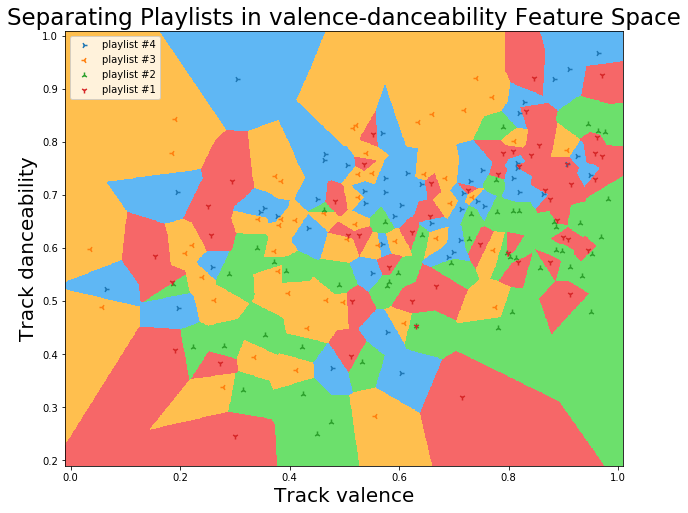

In [26]:
plt.figure(figsize=(10,8))

cmap_light = ListedColormap(['#5fb7f4', '#ffbf4e', '#6ce06c', '#f66768'])

clf = neighbors.KNeighborsClassifier(1)
clf.fit(combined_df2[['valence','danceability']], combined_df2['pid'])
xx, yy = np.meshgrid(np.arange(-0.01, 1.01, 0.001), np.arange(0.19, 1.01, 0.001))
Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
plt.pcolormesh(xx, yy, Z, cmap=cmap_light)



for playlist_id, mark in zip(np.unique(combined_df.pid)[30:34], ['4', '3', '2', '1']):
    plt.scatter(x=combined_df[combined_df.pid == playlist_id].valence, y=combined_df[combined_df.pid == playlist_id].danceability, marker=mark, label='playlist #'+mark)
plt.legend()
plt.xlabel('Track valence', fontsize=20)
plt.ylabel('Track danceability', fontsize=20)
plt.title('Separating Playlists in valence-danceability Feature Space', fontsize=23)

Note that most of the points are in the center, where there is extremely high variance in colors. It seems like regios on the plot edges are acceptable, but this is actually due to dearth of data (large region, defined by single point), and is thus not likely to have good accuracy